## Setup

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

In [2]:
data = pd.read_csv("./train.csv", sep=",", encoding="utf8" )
test_data = pd.read_csv("./test.csv", sep=",", encoding="utf8" )

## EDA

In [3]:
correlation = data.corr(method='spearman')['IN_TREINEIRO']
corr_dict = correlation.to_dict()

# Get feature correlation for correlation minimum threshold
threshold = 0.1
[index for index, value in corr_dict.items() if value > threshold or value < - threshold]

['NU_IDADE',
 'TP_ESTADO_CIVIL',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'IN_TREINEIRO',
 'IN_CERTIFICADO',
 'Q030']

In [4]:
data.NU_IDADE.unique()

array([24, 17, 21, 25, 28, 18, 16, 29, 27, 19, 20, 30, 22, 15, 40, 23, 37,
       32, 38, 26, 42, 44, 34, 48, 31, 52, 43, 36, 45, 39, 57, 33, 49, 35,
       47, 46, 14, 51, 59, 56, 50, 41, 65, 55, 54, 53, 62, 63, 67, 61, 60,
       64, 58, 66, 13])

In [5]:
data[data["IN_TREINEIRO"] == 1].groupby("NU_IDADE").NU_IDADE.sum()

NU_IDADE
13       13
14      196
15     4020
16    13776
17    10166
18      738
Name: NU_IDADE, dtype: int64

In [6]:
validation = test_data.copy()
val_columns = validation.columns.tolist()

df = data[val_columns]
df["IN_TREINEIRO"] = data["IN_TREINEIRO"]
df = df.drop(columns=["CO_UF_RESIDENCIA", "NU_INSCRICAO"])
df = df.drop([  429,   914,  1280,  1775,  5124,  6253,  7126,  7656, 12475], axis=0)

na_percentage = df.isna().sum() / len(df)
pd.DataFrame(na_percentage[na_percentage.map(lambda x: x > 0)], columns=["NA_RATE"])

,NA_RATE
TP_ENSINO,0.688361
TP_DEPENDENCIA_ADM_ESC,0.688361
NU_NOTA_CN,0.246338
NU_NOTA_CH,0.246338
NU_NOTA_LC,0.261788
TP_STATUS_REDACAO,0.261788
NU_NOTA_COMP1,0.261788
NU_NOTA_COMP2,0.261788
NU_NOTA_COMP3,0.261788
NU_NOTA_COMP4,0.261788


## Preprocessing

In [7]:
X = df.drop('IN_TREINEIRO', axis=1)
y = df['IN_TREINEIRO']

# Since NA imputation method doesn't leak data from test set, the imputation will be done before the data is split

X.fillna(-1, inplace=True)

# Validation process mirror test preprocessing

validation = test_data.copy()
validation = validation.drop(columns=["CO_UF_RESIDENCIA", "NU_INSCRICAO"])
validation.fillna(-1, inplace=True)

### Feature Selection

In [8]:
categoric = X.columns[X.columns.str.match("^(TP_|SG_|Q0)")].tolist()
features = X.columns[X.columns.str.match("^(TP_|SG_|Q0|NU_IDADE|IN_CONCLUSAO)")].tolist()

X = X[features]
X = pd.get_dummies(X, columns=categoric, drop_first=True)
X.shape

(13721, 130)

In [9]:
tidyval = validation[features]
tidyval = pd.get_dummies(tidyval, columns=categoric, drop_first=True)
tidyval.shape

(4570, 130)

## Data Splitting

In [10]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.3, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((4116, 130), (9605, 130), (4116,), (9605,))

## Treat Imbalanced Data

In [11]:
treineiros = pd.DataFrame({"sum_treineiro": y_train.value_counts()})
treineiros.index = ["NAO", "SIM"]
treineiros

,sum_treineiro
NAO,3573
SIM,543


In [12]:
from imblearn.under_sampling import RandomUnderSampler


rus = RandomUnderSampler(random_state=0)

X_res, y_res = rus.fit_resample(X_train, y_train)
treineiros_res = pd.DataFrame({"sum_treineiro": y_res.value_counts()})
treineiros_res.index = ["NAO", "SIM"]
treineiros_res

,sum_treineiro
NAO,543
SIM,543


## Model Training

In [13]:
from sklearn.metrics import classification_report, plot_roc_curve, accuracy_score, plot_precision_recall_curve
from sklearn.svm import SVC


model = SVC(C=1, kernel='rbf', degree=3, gamma='auto', class_weight='balanced', max_iter=-1, random_state=0)

model.fit(X_res, y_res)
prediction = model.predict(X_test)

## Model Testing

In [14]:
print(f'Model accuracy: {accuracy_score(y_test, prediction) * 100:.2f}%')
print(classification_report(y_test, prediction))

Model accuracy: 98.31%
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      8366
           1       0.88      1.00      0.94      1239

    accuracy                           0.98      9605
   macro avg       0.94      0.99      0.96      9605
weighted avg       0.99      0.98      0.98      9605



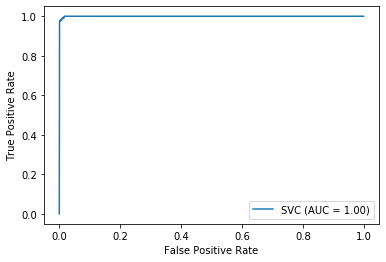

In [15]:
plot_roc_curve(model, X_test, y_test);

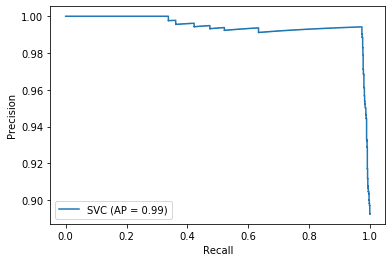

In [16]:
plot_precision_recall_curve(model, X_test, y_test);

## Validation

In [17]:
prediction = model.predict(tidyval)

In [18]:
answer = pd.DataFrame({
    "NU_INSCRICAO": test_data["NU_INSCRICAO"],
    "IN_TREINEIRO": prediction
})

answer.to_csv("./answer.csv", sep=",", encoding="utf8", index=False)

In [19]:
! codenation submit -c enem-4 

Versão: 1.0.14

Usando arquivo de configuração: /home/vcwild/.codenation.yml

Executando testes...

{"score": 98.57768052516411}
Preparando code review... 100% |████████████████████████████████████████|  [6s:0s]
Códigos submetidos com sucesso! 


Ops! Calma aí!

Você precisa esperar 1 minuto entre cada submissão.
Respire, pegue um café e envie novamente daqui a alguns segundos
